# Хакатон "Лента х Практикум"

## Описание проекта

**Краткое описание:**
Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного
производства. Гранулярность ТК-SKU-День.

**Термины:**
- ТК - Торговый комплекс
- SKU - Товар
- СП - собственное производство

**Задача:**
Построить модель прогноза спроса на основе мастер данных и данных продаж с учетом разных
признаков.

**Цель:**
Сгенерировать различные признаки и придумать интерпретируемую, описывающую правильные
зависимости (повышение цены вызывает логичное падение спроса), модель прогноза спроса.
Дальше необходимо сделать подневной прогноз спроса на тестовом периоде для каждого товара
и магазина, и команда Ленты оценит его качество в сравнении с свершившимся фактом.
Метрикой качества будет выступать WAPE, посчитанный на уровне товар, магазин, день. Если
есть пропущенные значения и по каким-то товарам не предоставлен прогноз, прогноз считается
равным нулю.

```python
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
```

**Требования к результату:**
1. Файл в зафиксированном формате с результатом прогноза спроса(sales_submission.csv).
2. Воспроизводимый код на Python
3. Описание решения:
    + Описание модели прогноза спроса, которую вы зафитили
        + Признаки
        + интерпретация (`shapley values`),
        + кросс-валидация
        + алгоритмы
    + Описание вашего алгоритма оптимизации:
        + методология расчетов
        + скорость оптимизации

**Критерии оценки:**
У вас есть тестовый датасет за более поздние периоды в рамках групп товаров собственного
производства. Ваш алгоритм должен показать высокую точность прогнозирования спроса с
использованием признаков, которые вы сочтёте нужными.
Критерии оценки – WAPE + алгоритм прогноза спроса является понятным, эффективным и
масштабируемым.

## Знакомство с данными

In [1]:
# импорт осн. библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорт спец. модулей Scikit-Learn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Константы
FIGSIZE = (15, 6)
RANDOM_STATE = 42

Исходный набор данных состоит из четырёх датасетов:
1. `pr_df.csv` - данные по товарной иерархии,
2. `pr_st.csv` - данные по магазинам,
3. `sales_df_train.csv` - данные по продажам за скользящий год для обучения,
4. `sales_submission.csv` - пример файла с результатом работы модели прогноза спроса.

In [3]:
#чтение датасетов
pr_df = pd.read_csv('datasets/pr_df.csv')
pr_st = pd.read_csv('datasets/st_df.csv')
sales_df_train = pd.read_csv('datasets/sales_df_train.csv', parse_dates=['date'])
sales_submission = pd.read_csv('datasets/sales_submission.csv', parse_dates=['date'])

holidays_covid_calendar = pd.read_csv('datasets/holidays_covid_calendar.csv',
                                      index_col='date',
                                      parse_dates=['date'],
                                      date_format='%d.%m.%Y')

### Товарная иерархия

Это сводная таблица, несущая исключительно информационный характер. Описание колонок по значению, от большего к меньшему: pr_group_id -> pr_cat_id -> pr_subcat_id -> pr_sku_id.
- `pr_group_id` – захэшированная группа товара;
- `pr_cat_id` – захэшированная категория товара;
- `pr_subcat_id` – захэшированная подкатегория товара;
- `pr_sku_id` – захэшированное id товара;
- `pr_uom_id` - маркер, обозначающий продаётся товар на вес или в ШТ.

In [4]:
# изменение порядка между столбцами
pr_df = pr_df[['pr_group_id', 'pr_cat_id', 'pr_subcat_id', 'pr_sku_id', 'pr_uom_id']]

display(pr_df)
print(pr_df.info())
print('Кол-во явных дубликатов:', pr_df.duplicated().sum())

,pr_group_id,pr_cat_id,pr_subcat_id,pr_sku_id,pr_uom_id
0,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,fd064933250b0bfe4f926b867b0a5ec8,17
1,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,71c9661741caf40a92a32d1cc8206c04,17
2,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,00b72c2f01a1512cbb1d3f33319bac93,17
3,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,ca34f669ae367c87f0e75dcae0f61ee5,9bc40cd2fe4f188f402bb41548c5e15c,17
4,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,e06f5ed77191826c212c30722f2cc5a2,3a74a370c8eb032acb11ad9119242b8f,17
...,...,...,...,...,...
2045,c74d97b01eae257e44aa9d5bade97baf,a2cc63e065705fe938a4dda49092966f,4589b8f516d28558b3850c37776cadc8,2c3b895d9fccc33226fee2c521618893,1
2046,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,c0a667df8f0d6ee98dda972b0870fabf,6058d6b7d1f04803d15d1896d3256c92,1
2047,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,34d2777e78ccf007523e2dd1fcea6b2d,3beeab85046ca201d73bb9d129bcfc3f,17
2048,aab3238922bcc25a6f606eb525ffdc56,3de2334a314a7a72721f1f74a6cb4cee,0f3abfd67959c079e7b3759440e7415c,b9e2f33d70ffb02d6d04f470da2e45c9,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_group_id   2050 non-null   object
 1   pr_cat_id     2050 non-null   object
 2   pr_subcat_id  2050 non-null   object
 3   pr_sku_id     2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB
None
Кол-во явных дубликатов: 0


In [5]:
# подсчёт кол-ва уникальных значений
print('Кол-во групп:', len(pr_df['pr_group_id'].unique()))
print('Кол-во категорий:', len(pr_df['pr_cat_id'].unique()))
print('Кол-во подкатегорий:', len(pr_df['pr_subcat_id'].unique()))
print('Кол-во уникальных товаров:', len(pr_df['pr_sku_id'].unique()))
print('Значения меток фасовки товаров (на вес / поштучно):', pr_df['pr_uom_id'].unique())

Кол-во групп: 9
Кол-во категорий: 43
Кол-во подкатегорий: 170
Кол-во уникальных товаров: 2050
Значения меток фасовки товаров (на вес / поштучно): [17  1]


Пропуски отсутствуют. Столбец `pr_sku_id` содержит уникальные значения и может выполнять роль индекса (первичного ключа). Тип данных соответствует, за исключения столбца `pr_uom_id`. Возможно, для него подойдёт bool-ый тип данных, поскольку значения бинарны.

### Данные по магазинам

Это сводная таблица, несущая исключительно информационный характер. Описание столбцов:
- `st_id` – захэшированное id магазина;
- `st_city_id` – захэшированное id города;
- `st_division_code id` – захэшированное id дивизиона;
- `st_type_format_id` – id формата магазина;
- `st_type_loc_id` – id тип локации/окружения магазина;
- `st_type_size_id` – id типа размера магазина;
- `st_is_active` – флаг активного магазина на данный момент.

In [6]:
display(pr_st)
print(pr_st.info())
print('Кол-во явных дубликатов:', pr_st.duplicated().sum())

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
1,bd470ca955d9497bbcb808e59952fffc,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,19,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
3,1ecfb463472ec9115b10c292ef8bc986,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,2,1,28,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,c1f75cc0f7fe269dd0fd9bd5e24f9586,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,1
5,53e19f3dbb211f20b20b45668303c1b6,955d864a62659945cc9434898e275deb,e26072c92d8fe0738df44d571d5f5e8b,4,3,20,1
6,42a0e188f5033bc65bf8d78622277c4e,b8b4b727d6f5d1b61fff7be687f7970f,da742b3cfca5388aaf9af28a726a3c30,1,1,12,1
7,c81e728d9d4c2f636f067f89cc14862c,908c9a564a86426585b29f5335b619bc,429a86ff6336c144ddaf6144f52ab52c,1,1,8,1
8,fa7cdfad1a5aaf8370ebeda47a1ff1c3,885fe656777008c335ac96072a45be15,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,1
9,f7e6c85504ce6e82442c770f7c8606f0,3202111cf90e7c816a472aaceb72b0df,32586311f16876abf92901085bd87b99,1,1,12,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 804.0+ bytes
None
Кол-во явных дубликатов: 0


In [7]:
# уникальные значения
print('Кол-во магазинов:', len(pr_st['st_id'].unique()))
print('Кол-во городов:', len(pr_st['st_city_id'].unique()))
print('Кол-во дивизионов:', len(pr_st['st_division_code'].unique()))
print('Форматы магазинов:', pr_st['st_type_format_id'].unique())
print('Типы локации/окружения:', pr_st['st_type_loc_id'].unique())
print('Типы размеров магазина:', pr_st['st_type_size_id'].unique())

Кол-во магазинов: 12
Кол-во городов: 7
Кол-во дивизионов: 6
Форматы магазинов: [4 1 2]
Типы локации/окружения: [3 1 2]
Типы размеров магазина: [19 12 28  8 20 32]


In [8]:
# не активные магазины
display(pr_st[pr_st['st_is_active'] == 0])
not_active_st_id = pr_st.loc[pr_st['st_is_active'] == 0, 'st_id'].values

,st_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
0,1aa057313c28fa4a40c5bc084b11d276,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,19,0
10,62f91ce9b820a491ee78c108636db089,1587965fb4d4b5afe8428a4a024feb0d,81b4dd343f5880df806d4c5d4a846c64,4,3,32,0


Всего 12 магазинов в 7 городах (6 дивизионах), которые расположены на 3х типах локаций. Среди них встречаются 3 формата магазинов: 1, 2 и 4 (внезапно), а так же 6 типоа размера магазинов. Все эти признаки **категориальные** и подлежат кодированию, возможно.

Два магазина, не действующих на данный момент, вероятно стоит удалить, поскольку прогнозирование для него не целесообразно.

### Данные по продажам

Данные собраны за скользящий год. Предназначены для обучения. В датасете не содержатся данных о списании невостребованных/неликвидных остатков товаров. Описание столбцов:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата;
- `pr_sales_type_id` – флаг наличия промо;
- `pr_sales_in_units` – число проданных товаров всего (с промо и без);
- `pr_promo_sales_in_units` – число проданных товаров с признаком промо;
- `pr_sales_in_rub` – продажи товаров всего (с промо и без);
- `pr_promo_sales_in_rub` – продажи с признаком промо в РУБ.

In [9]:
display(sales_df_train)
print(sales_df_train.info())
print('Кол-во явных дубликатов:', sales_df_train.duplicated().sum())
print('Кол-во магазинов, находящихся в торговле:', len(sales_df_train['st_id'].unique()))
print('Кол-во наименований товаров, находящихся в продаже:', len(sales_df_train['pr_sku_id'].unique()))

since = sales_df_train['date'].min().date()
to = sales_df_train['date'].max().date()
print('Временной период: от {} до {} ({} суток)'.format(since, to, (to-since).days+1))

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0
...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,2022-12-13,1,1.0,1.0,33.0,33.0
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,2023-04-18,0,1.0,0.0,192.0,0.0
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,2022-08-16,0,5.0,0.0,970.0,0.0
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,2023-04-23,0,4.0,0.0,262.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   st_id                    883015 non-null  object        
 1   pr_sku_id                883015 non-null  object        
 2   date                     883015 non-null  datetime64[ns]
 3   pr_sales_type_id         883015 non-null  int64         
 4   pr_sales_in_units        883015 non-null  float64       
 5   pr_promo_sales_in_units  883015 non-null  float64       
 6   pr_sales_in_rub          883015 non-null  float64       
 7   pr_promo_sales_in_rub    883015 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 53.9+ MB
None


Кол-во явных дубликатов: 0
Кол-во магазинов, находящихся в торговле: 12
Кол-во наименований товаров, находящихся в продаже: 1991
Временной период: от 2022-08-01 до 2023-07-18 (352 суток)


Таблица содержит более 880 тыс. записей о продажах. Каждая запись фиксирует "Где? Что? Когда?" было продано, а также кол-во, стоимость и условия этих продаж (промо-акция / нет). Фактически данные собраны за неполный год (подробности выше).

**Планы:**
- Стоит проконтролировать тип данных в столбцах: `pr_sales_in_units`, `pr_promo_sales_in_units`,	`pr_sales_in_rub`,	`pr_promo_sales_in_rub`
- Стоит проконтролировать целостность временной линии.
- Стоит ли устранить недочет с равенством `pr_sales_in_units` и `pr_promo_sales_in_units`, когда `pr_sales_type_id` равно 1?
- Возможно стоит изменить тип данных столбцов с датами на `datetime64`

### Пример файла с результатом работы модели прогноза спроса

Необходимо подготовить файл в таком же формате, заполнив колонку target предсказаниями (по
умолчанию колонка заполнена нулями). Столбцы:
- `st_id` – захэшированное id магазина;
- `pr_sku_id` – захэшированное id товара;
- `date` – дата (день);
- `target` – спрос в ШТ.

In [10]:
display(sales_submission)
print(sales_submission.info())
print('Кол-во явных дубликатов:', sales_submission.duplicated().sum())

since = sales_submission['date'].min().date()
to = sales_submission['date'].max().date()
print('Временной период: от {} до {} ({} дней)'.format(since, to, (to-since).days+1))

,st_id,pr_sku_id,date,target
0,16a5cdae362b8d27a1d8f8c7b78b4330,0045ebdb1069ff4b3dd3efe628c39cd3,2023-07-20,0
1,16a5cdae362b8d27a1d8f8c7b78b4330,00661699f543753ec7e911a64b9fd2f6,2023-07-20,0
2,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2023-07-20,0
3,16a5cdae362b8d27a1d8f8c7b78b4330,0169529ff660adcac9b7e354e0c4b882,2023-07-20,0
4,16a5cdae362b8d27a1d8f8c7b78b4330,01e4734745e97e52d3213449e1a05dd7,2023-07-20,0
...,...,...,...,...
43689,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fd519eb13005448a303df1089505a42b,2023-08-01,0
43690,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fdb89dfd1a27256904eb5a5734252102,2023-08-01,0
43691,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-08-01,0
43692,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe5d18ae6650335830e4c1dbd9e6ddb9,2023-08-01,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43694 entries, 0 to 43693
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   st_id      43694 non-null  object        
 1   pr_sku_id  43694 non-null  object        
 2   date       43694 non-null  datetime64[ns]
 3   target     43694 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.3+ MB
None
Кол-во явных дубликатов: 0
Временной период: от 2023-07-19 до 2023-08-01 (14 дней)


### Календарь праздников

In [11]:
holidays_covid_calendar = holidays_covid_calendar.loc[sales_df_train['date'].min() : sales_df_train['date'].max()]
display(holidays_covid_calendar)
print(holidays_covid_calendar.info())

,year,day,weekday,calday,holiday,covid
date,,,,,,
2022-08-01,2022,1,1,20220801,0,0
2022-08-02,2022,2,2,20220802,0,0
2022-08-03,2022,3,3,20220803,0,0
2022-08-04,2022,4,4,20220804,0,0
2022-08-05,2022,5,5,20220805,0,0
...,...,...,...,...,...,...
2023-07-14,2023,14,5,20230714,0,0
2023-07-15,2023,15,6,20230715,1,0
2023-07-16,2023,16,7,20230716,1,0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-08-01 to 2023-07-18
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   year     352 non-null    int64
 1   day      352 non-null    int64
 2   weekday  352 non-null    int64
 3   calday   352 non-null    int64
 4   holiday  352 non-null    int64
 5   covid    352 non-null    int64
dtypes: int64(6)
memory usage: 19.2 KB
None


**Промежуточный вывод:**
- наименование столбцов выполнено в едином стандарте,
- тип данных - соответствует,
- пропуски и явные дубликаты - отсутствуют во всех датасетах.

Основным датасетом является `sales_df_train`, поскольку он содержит основную информацию для работы. В его состав входит около 880 000 записей о продажах, а если быть точнее: о поступлении и уходе денежных средств. Таким образом я хочу сказать, что каждый столбец с количественной информацией необходимо проверить на выбросы/аномалии и соответствие с заявленными данными. Этому будет посвящен следующий раздел.

___

## Разведочный анализ данных

Ориентировочный план анализа:
- (День — Товар — Магазин — Продажа в штуках — Продажа в рублях — доля продаж по ПРОМО)
- Построить графики временных рядов
- Исследовать пропуски, выбросы и корреляции между товарами, заполнить пропуски, нивелировать выбросы
- Провести предобработку данных

### Распределение продаж

In [12]:
# продажи в двух магазинах, закрытых на данный момент
display(sales_df_train[sales_df_train['st_id'].isin(not_active_st_id)])

since = sales_df_train.loc[sales_df_train['st_id'].isin(not_active_st_id), 'date'].min().date()
to = sales_df_train.loc[sales_df_train['st_id'].isin(not_active_st_id), 'date'].max().date()
print('Временной период: от {} до {} ({} суток)'.format(since, to, (to-since).days+1))

sales_df_train = sales_df_train[~sales_df_train['st_id'].isin(not_active_st_id)] # исключение закрытых магазинов

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
678,1aa057313c28fa4a40c5bc084b11d276,5b26f85ccb23039364226f66f0366c66,2022-08-23,0,2.0,0.0,36.0,0.0
888,1aa057313c28fa4a40c5bc084b11d276,5aa2f6e00873f8c90b00cd15d670daa1,2022-08-04,1,2.0,2.0,115.0,115.0
3549,1aa057313c28fa4a40c5bc084b11d276,5b26f85ccb23039364226f66f0366c66,2022-08-17,0,4.0,0.0,89.0,0.0
5830,1aa057313c28fa4a40c5bc084b11d276,3a74a370c8eb032acb11ad9119242b8f,2022-08-15,0,1.0,0.0,65.0,0.0
9097,1aa057313c28fa4a40c5bc084b11d276,71c9661741caf40a92a32d1cc8206c04,2022-08-05,1,1.0,1.0,66.0,66.0
...,...,...,...,...,...,...,...,...
879615,1aa057313c28fa4a40c5bc084b11d276,3a74a370c8eb032acb11ad9119242b8f,2022-08-26,1,1.0,1.0,59.0,59.0
879706,1aa057313c28fa4a40c5bc084b11d276,fd064933250b0bfe4f926b867b0a5ec8,2022-08-02,0,3.0,0.0,73.0,0.0
879709,1aa057313c28fa4a40c5bc084b11d276,66a5198a8d1afbef4821b8cebf7f794d,2022-08-12,0,8.0,0.0,115.0,0.0
881605,1aa057313c28fa4a40c5bc084b11d276,e95b9bb287e5571345c0e94f3118d667,2022-08-23,0,4.0,0.0,262.0,0.0


Временной период: от 2022-08-01 до 2022-09-08 (39 суток)


Кол-во записей о продажах в закрытых магазинах составляет меньше 0.1% от общего числа. Этого недостаточно для предсказания, тем более в этом нет необходимости. Эти данные стоит удалить, чтобы они не могли оказывать влияние на актуальные данные.

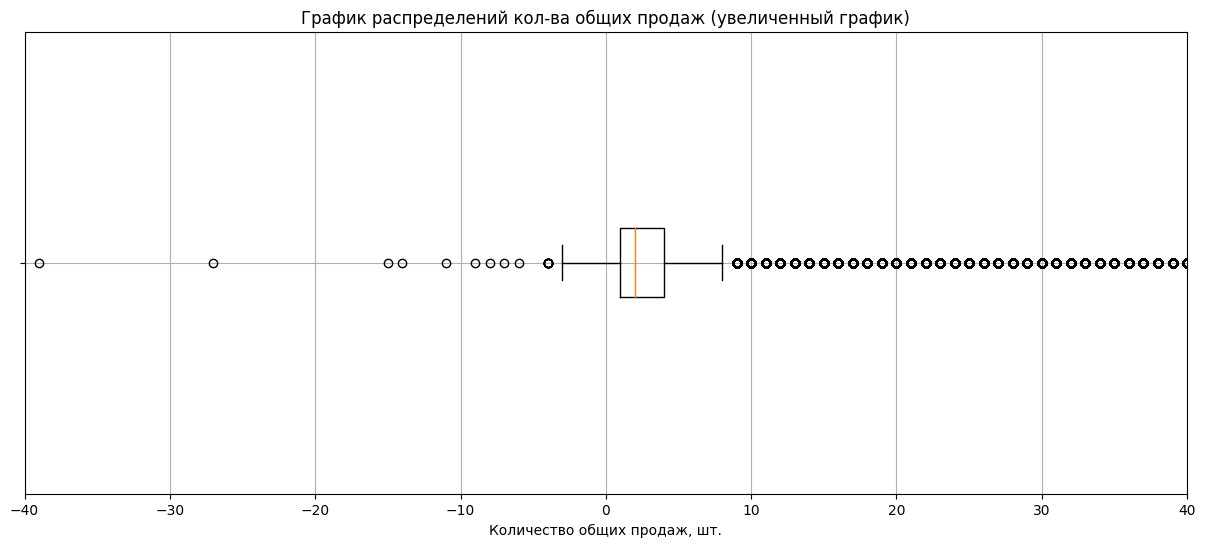

,pr_sales_in_units
count,882286.000000
mean,5.039530
std,13.408266
min,-39.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,2348.000000


In [13]:
# распределение продаж
plt.figure(figsize=FIGSIZE)
plt.boxplot(sales_df_train['pr_sales_in_units'], vert=False, labels=[''])
plt.title('График распределений кол-ва общих продаж (увеличенный график)')
plt.xlabel('Количество общих продаж, шт.')
plt.xlim(-40, 40)
plt.grid(True)
plt.show()

sales_df_train['pr_sales_in_units'].describe().to_frame()

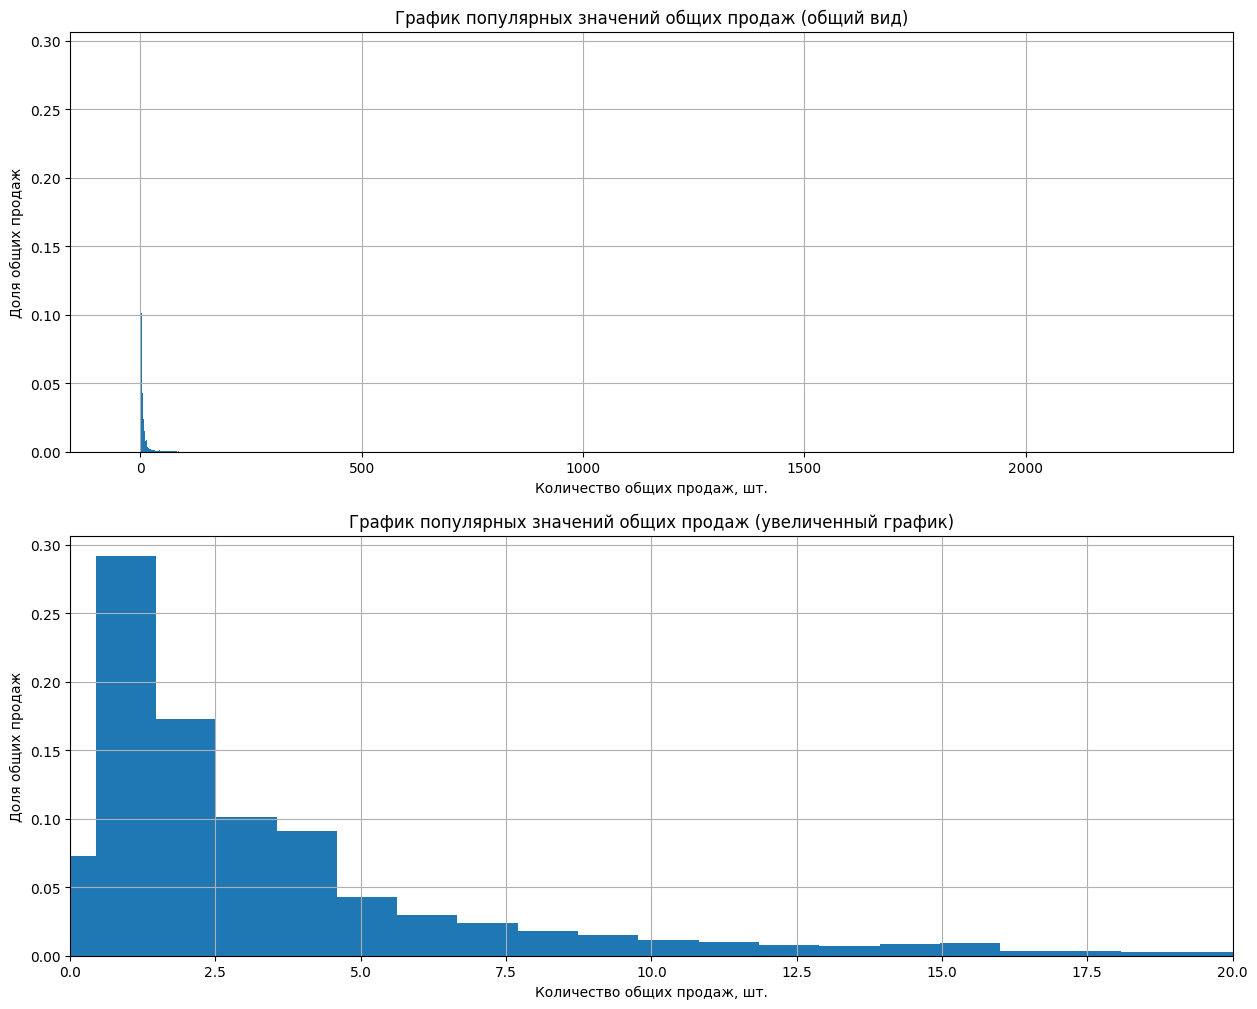

In [14]:
# распределение положительных значений общих продаж
fig, axs = plt.subplots(2, 1, figsize=(15, 12))

axs[0].hist(sales_df_train['pr_sales_in_units'], density=True, bins=2300)
axs[0].set_title('График популярных значений общих продаж (общий вид)')
axs[0].set_ylabel('Доля общих продаж')
axs[0].set_xlabel('Количество общих продаж, шт.')
axs[0].grid(True)

axs[1].hist(sales_df_train['pr_sales_in_units'], density=True, bins=2300)
axs[1].set_title('График популярных значений общих продаж (увеличенный график)')
axs[1].set_ylabel('Доля общих продаж')
axs[1].set_xlabel('Количество общих продаж, шт.')
axs[1].set_xlim(0, 20)
axs[1].grid(True)
plt.show()

In [15]:
# кол-во отрицательных и нулевых общих продаж
negative_sales_in_units = sales_df_train[sales_df_train['pr_sales_in_units'] <= 0].value_counts('pr_sales_in_units',
                                                                                               sort=False).to_frame()
negative_sales_in_units.loc['Total:', 'count'] = negative_sales_in_units['count'].sum()
negative_sales_in_units['count'] = negative_sales_in_units['count'].astype('int')

display(negative_sales_in_units)
del negative_sales_in_units

,count
pr_sales_in_units,
-39.0,1
-27.0,1
-15.0,1
-14.0,1
-11.0,1
-9.0,1
-8.0,1
-7.0,1
-6.0,1


Столбец `pr_sales_in_units`, отображающий общее кол-во продаж товара содержит крайне большие значения, а так же отрицательные значения. 

Крайне большие значение встречаются очень редко. Их присутствие сильно сказывается на распределении продаж. По этой причине от них необходимо избавиться. Границей между нормальными значениями и выбросами будет сумма 3-его квантиля и стандартного отклонения (Q3 + std) или воспользоваться правилом "трёх сигм" (mean + 3*std).

Отрицательных значений не много 71 объект. Судя по частоте их встречи, предполагаю, что вероятней это возвраты. Чаще всего возвращали одну единицу товара, и значительно реже возвращали 6 и более товаров единовременно. Исключив отрицательные значения.
Аналогично можно поступить с "нулевыми" продажами, которых 453 объекта.

Установив такие границы, выбросами и аномалиями будут признаны ~5% данных.

In [16]:
# общие продажи в "нормальных" пределах
min_sales = 0
max_sales = sales_df_train['pr_sales_in_units'].quantile(0.75) + sales_df_train['pr_sales_in_units'].std()

display(sales_df_train[(sales_df_train['pr_sales_in_units'] >= min_sales) &
                       (sales_df_train['pr_sales_in_units'] <= max_sales)])


sales_df_train = sales_df_train[sales_df_train['pr_sales_in_units'] >= min_sales] # исключение отрицательных продаж
#                              (sales_df_train['pr_sales_in_units'] <= max_sales) # аномально большие продажи - остаются

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0
...,...,...,...,...,...,...,...,...
883010,c81e728d9d4c2f636f067f89cc14862c,a0150fefa71d6606d5e642fa0e7b8ad8,2022-12-13,1,1.0,1.0,33.0,33.0
883011,42a0e188f5033bc65bf8d78622277c4e,5b146d93f822459260216df28e572eca,2023-04-18,0,1.0,0.0,192.0,0.0
883012,42a0e188f5033bc65bf8d78622277c4e,c8bd18ea08d2f47cb0a7992f11ada9de,2022-08-16,0,5.0,0.0,970.0,0.0
883013,f7e6c85504ce6e82442c770f7c8606f0,b960c6ee5b5efa12e73f810204b561a8,2023-04-23,0,4.0,0.0,262.0,0.0


### Аномальные значения

В этом разделе будут проанализированы 2 условные группы:
- _возвраты_ - факт возврата отсутствует, но есть уход денежных средств,
- _неучтённые операции_ - факт продажи отсутствует, но есть поступление денежных средств,
- _убытки_ - факт продажи присутствует, но поступление денежных средств нет.

In [17]:
# возвраты
negative_sales_in_rub = sales_df_train[(sales_df_train['pr_sales_in_rub'] < 0) & (sales_df_train['pr_sales_in_units'] >= 0)]
display(negative_sales_in_rub)

sales_df_train = sales_df_train[~sales_df_train.index.isin(negative_sales_in_rub.index)] # исключение возвраты
del negative_sales_in_rub

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
43146,f7e6c85504ce6e82442c770f7c8606f0,699dc7822b719137e8124b728ab45fa3,2022-11-10,1,-0.0,-0.0,-32.0,-32.0
252813,6364d3f0f495b6ab9dcf8d3b5c6e0b01,480c8cfe6acee2ea1d6f1c63bb80f226,2022-12-04,1,-0.0,-0.0,-321.0,-321.0
333287,42a0e188f5033bc65bf8d78622277c4e,6464ba75236f5928023d75e46ea8a328,2022-11-16,0,-0.0,0.0,-290.0,0.0
455113,f7e6c85504ce6e82442c770f7c8606f0,fe50ae64d08d4f8245aaabc55d1baf79,2022-08-03,0,-0.0,0.0,-23.0,0.0
491005,f7e6c85504ce6e82442c770f7c8606f0,bf5f373eede102c71bf77874c78bdc59,2022-10-20,0,-0.0,0.0,-27.0,0.0
618130,42a0e188f5033bc65bf8d78622277c4e,d2de88fc7856a5f50c05e8d9b7a20838,2022-10-30,0,-0.0,0.0,-13.0,0.0
790016,6364d3f0f495b6ab9dcf8d3b5c6e0b01,0a2090e24b6ae62b0b0fcaa67a72b5a0,2023-07-06,0,0.0,0.0,-140.0,0.0
849426,c81e728d9d4c2f636f067f89cc14862c,4ce0eb956648ab3ff6bb0afa3158cc42,2023-01-31,0,-0.0,0.0,-51.0,0.0


In [18]:
# неучтённые операции (факт продажи - отсутствует, но есть поступление денежных средств)
zero_sales_in_units = sales_df_train[(sales_df_train['pr_sales_in_units'] == 0) &
                                     (sales_df_train['pr_sales_in_rub']   != 0)]
display(zero_sales_in_units)
zero_sales_in_units['pr_sales_in_rub'].describe().to_frame()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
6,f7e6c85504ce6e82442c770f7c8606f0,b75c7cbf7accdaea8a1a14781bb29870,2023-02-15,0,0.0,0.0,171.0,0.0
27,42a0e188f5033bc65bf8d78622277c4e,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2022-11-10,0,0.0,0.0,91.0,0.0
28,f7e6c85504ce6e82442c770f7c8606f0,88d7313785c97631bf3df61e70636491,2022-11-30,0,0.0,0.0,79.0,0.0
32,fa7cdfad1a5aaf8370ebeda47a1ff1c3,b610088ddf586449793d3c6da70d4c56,2023-02-26,0,0.0,0.0,83.0,0.0
...,...,...,...,...,...,...,...,...
882978,fa7cdfad1a5aaf8370ebeda47a1ff1c3,a1f93a1aeb02759147d69276c70217db,2023-06-07,1,0.0,0.0,30.0,30.0
882979,6364d3f0f495b6ab9dcf8d3b5c6e0b01,cda72490a16c471e7a192a956f476e95,2023-04-11,0,0.0,0.0,62.0,0.0
882991,16a5cdae362b8d27a1d8f8c7b78b4330,7d945116ed12c2807d081df6f666ba37,2023-07-01,1,0.0,0.0,70.0,70.0
883004,42a0e188f5033bc65bf8d78622277c4e,143f62003066d8d4cc33d3e9161d114d,2022-12-25,1,0.0,0.0,41.0,41.0


,pr_sales_in_rub
count,66081.000000
mean,79.561811
std,61.323027
min,1.000000
25%,46.000000
50%,67.000000
75%,94.000000
max,832.000000


Возможно, _неучтённая сумма_ - это денежный остаток не внесённый в кассу в конце прошлого дня (пример №1). Или, _неучтённая сумма_ - это остаток не внесённый в кассу за текущий день (пример №2). Во всех примерах демонстрируется продажа одного товара в конкретном магазине, в конкретный день.

In [19]:
# Пример №1 - 4 апреля было продано 2 товара, а следующим днём 0. Но 5 апреля зафиксировано зачисление денег без продажи.
sales_df_train[(sales_df_train['st_id'] == '42a0e188f5033bc65bf8d78622277c4e') &
               (sales_df_train['pr_sku_id'] == '8e887cf8e64ab8e7173701a979476567') &
               ((sales_df_train['date'] == '2023-04-04') |
                (sales_df_train['date'] == '2023-04-05'))].sort_values(by='date')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
693245,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-04,1,2.0,2.0,268.0,268.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0


In [20]:
# Пример №2 - в течении дня была зафиксирована одна продажа, но два зачисления денежных средств. 
sales_df_train[(sales_df_train['st_id'] == '42a0e188f5033bc65bf8d78622277c4e') &
               (sales_df_train['pr_sku_id'] == 'cfb54b1ce12bb3f9b6b9e2ea0b57414b') &
               (sales_df_train['date'] == '2022-11-10')]

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
27,42a0e188f5033bc65bf8d78622277c4e,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2022-11-10,0,0.0,0.0,91.0,0.0
118590,42a0e188f5033bc65bf8d78622277c4e,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2022-11-10,1,1.0,1.0,206.0,206.0


In [21]:
# нетипичная ситуация: стоимость товара с промо-акцией дороже, чем без неё 
sales_df_train[(sales_df_train['st_id'] == 'fa7cdfad1a5aaf8370ebeda47a1ff1c3') &
               (sales_df_train['pr_sku_id'] == '6e822618c30449cfabec9b22a7de1425') &
               (sales_df_train['date'] == '2023-07-18')].sort_values(by='pr_sales_type_id')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
294320,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6e822618c30449cfabec9b22a7de1425,2023-07-18,0,1.0,0.0,174.0,0.0
811860,fa7cdfad1a5aaf8370ebeda47a1ff1c3,6e822618c30449cfabec9b22a7de1425,2023-07-18,1,1.0,1.0,245.0,245.0


Возможны и другие объяснения, но для этого необходимо провести анализ совместно с соответствующим специалистом со стороны заказчика. Без этого аномалии нельзя объяснить однозначно, и соответственно, принять грамотное решение по их учёту. По этой причине все продажи содержащие поступление денежных средств, но без указания кол-ва товаров - будут исключены.

In [22]:
# убытки (факт продажи - присутствует, но поступление денежных средств нет)
zero_sales_in_rub = sales_df_train[(sales_df_train['pr_sales_in_units'] != 0) &
                                   (sales_df_train['pr_sales_in_rub']   == 0)]
display(zero_sales_in_rub)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
30,f7e6c85504ce6e82442c770f7c8606f0,3474f0e025c7deb7e127a35763bc5512,2023-06-06,1,8.0,8.0,0.0,0.0
6313,53e19f3dbb211f20b20b45668303c1b6,ee21c04f96ab30a8b3ca761e57e016ca,2022-11-09,1,1.0,1.0,0.0,0.0
7432,c81e728d9d4c2f636f067f89cc14862c,90252502ab29331e94fd3113f11c58e0,2022-12-27,1,2.0,2.0,0.0,0.0
8153,f7e6c85504ce6e82442c770f7c8606f0,4e3d5c9fab3fc51a4857846fea3d2e57,2022-12-19,1,1.0,1.0,0.0,0.0
8931,f7e6c85504ce6e82442c770f7c8606f0,0f152427918d29bb1081834c1d375a48,2022-10-28,1,2.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...
876801,1ecfb463472ec9115b10c292ef8bc986,525526d5b2169462195c44d49fff4a44,2022-10-22,1,1.0,1.0,0.0,0.0
878163,fa7cdfad1a5aaf8370ebeda47a1ff1c3,27e8978c9e8b7146c462feb7d24f5637,2022-10-27,1,9.0,9.0,0.0,0.0
882360,6364d3f0f495b6ab9dcf8d3b5c6e0b01,2dc922d957188fb51dd2bd50ec9b555a,2022-10-29,1,12.0,12.0,0.0,0.0
882380,f7e6c85504ce6e82442c770f7c8606f0,9da31b9d3cf407cd724c65b7dfed00ee,2022-11-27,1,3.0,3.0,0.0,0.0


In [23]:
# абсолютно нулевые продажи
absolut_zero_sale = sales_df_train[sales_df_train['pr_sales_in_units'] == 0]

print('Уникальные значения в колонке "pr_sales_in_units"      :', absolut_zero_sale['pr_sales_in_units'].unique())
print('Уникальные значения в колонке "pr_promo_sales_in_units":', absolut_zero_sale['pr_promo_sales_in_units'].unique())
print('Уникальные значения в колонке "pr_sales_in_rub"        :', absolut_zero_sale['pr_sales_in_rub'].unique())
print('Уникальные значения в колонке "pr_promo_sales_in_rub"  :', absolut_zero_sale['pr_promo_sales_in_rub'].unique())

display(absolut_zero_sale)

Уникальные значения в колонке "pr_sales_in_units"      : [0.]
Уникальные значения в колонке "pr_promo_sales_in_units": [0.]
Уникальные значения в колонке "pr_sales_in_rub"        : [ 69. 171.  91.  79.  83. 136.  67.  48.  32. 119.  84.  30.  61. 165.
 105.  50.  95. 150.  62.  36.  23.  71. 138. 230.  54.  41.  94.  39.
  70. 130.  75.  56.  45.  24.  38.  82.  87. 156.  42. 133.  80.  37.
   5.  35.  19.  86.  65.  88. 146. 125.  51. 118.  59. 127.  96.  44.
  68.  28.  20.  89.  49.  52. 163.  47.  57. 126.  63. 103. 101. 175.
  31.   0. 109. 132.  64.  46.  55.  77.  97. 410.  43.  73.  17.  53.
  34.  76.  66.  29. 435.  58. 241. 188. 210.  40.  92. 134. 111. 281.
  98. 151.  22.  78. 117. 120. 110.  21. 107.  90. 360. 137.  74.  33.
  93.  85.  26.  15. 122. 491. 113. 316.  81. 100.  25. 214. 131.  60.
 194. 116.  10. 108. 124. 174.  72.  11. 292.  16.  27. 218. 358. 106.
 160. 149. 114. 493. 408. 446. 121. 243. 143. 142. 123. 216. 104.  14.
 199. 135. 178. 511. 141. 147. 315. 25

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
6,f7e6c85504ce6e82442c770f7c8606f0,b75c7cbf7accdaea8a1a14781bb29870,2023-02-15,0,0.0,0.0,171.0,0.0
27,42a0e188f5033bc65bf8d78622277c4e,cfb54b1ce12bb3f9b6b9e2ea0b57414b,2022-11-10,0,0.0,0.0,91.0,0.0
28,f7e6c85504ce6e82442c770f7c8606f0,88d7313785c97631bf3df61e70636491,2022-11-30,0,0.0,0.0,79.0,0.0
32,fa7cdfad1a5aaf8370ebeda47a1ff1c3,b610088ddf586449793d3c6da70d4c56,2023-02-26,0,0.0,0.0,83.0,0.0
...,...,...,...,...,...,...,...,...
882978,fa7cdfad1a5aaf8370ebeda47a1ff1c3,a1f93a1aeb02759147d69276c70217db,2023-06-07,1,0.0,0.0,30.0,30.0
882979,6364d3f0f495b6ab9dcf8d3b5c6e0b01,cda72490a16c471e7a192a956f476e95,2023-04-11,0,0.0,0.0,62.0,0.0
882991,16a5cdae362b8d27a1d8f8c7b78b4330,7d945116ed12c2807d081df6f666ba37,2023-07-01,1,0.0,0.0,70.0,70.0
883004,42a0e188f5033bc65bf8d78622277c4e,143f62003066d8d4cc33d3e9161d114d,2022-12-25,1,0.0,0.0,41.0,41.0


In [24]:
# исключение аномалий
sales_df_train = sales_df_train[~sales_df_train.index.isin(zero_sales_in_units.index)]
sales_df_train = sales_df_train[~sales_df_train.index.isin(zero_sales_in_rub.index)]
sales_df_train = sales_df_train[~sales_df_train.index.isin(absolut_zero_sale.index)]

print('Остаточная численность датасета: {} объектов.'.format(sales_df_train.shape[0]))

del zero_sales_in_units
del zero_sales_in_rub
del absolut_zero_sale

Остаточная численность датасета: 814881 объектов.


Предположение: Если промо-акция действует в течении всего дня, то все товар можно приобрести либо по фактической цене, либо по промо-цене. Промежуточных вариантов нет. В таком случа столбцы `pr_promo_sales_in_units` и `pr_promo_sales_in_rub` не играют важной роли. Достаточно информации о наличии/отсутствии акции из столбца `pr_sales_type_id`.

В процессе анализа предположение не подтвердилось. В течение всего дня, товар можно преобрести как по фактической стоимости, так и по сниженной, воспользовавшись картой постоянного покупателя или другими привелегиями/льготами. Более подробному разбору посвещён следующий раздел.

### Неявные дубликаты

Под ними подразумевается раздвоение продаже товара с промо и без. Для каждого случая отдельная строчка. Из общего объёма датасета ~300 000 объектов (36%) - продублированы. Проблема заключается в том, что столбец `pr_sales_in_units` - изначально не показывает общее кол-во продаж. Ниже приведёт примеры демонстрирующий эту проблему и объём данных.

Исключением являются случае в которых все продажи были зафиксированы по одной цене (либо с промо, либо без).

In [25]:
# неявные дубликаты. необходима группировка
sales_df_train[sales_df_train[['st_id', 'pr_sku_id', 'date']].duplicated(keep=False)].sort_values(by=['date',
                                                                                                      'st_id',
                                                                                                      'pr_sku_id',
                                                                                                      'pr_sales_type_id'])

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
728531,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-01,0,4.0,0.0,712.0,0.0
550849,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-01,1,2.0,2.0,383.0,383.0
129271,16a5cdae362b8d27a1d8f8c7b78b4330,08dc3a654abf4087cedd4b03684c5862,2022-08-01,0,4.0,0.0,131.0,0.0
666268,16a5cdae362b8d27a1d8f8c7b78b4330,08dc3a654abf4087cedd4b03684c5862,2022-08-01,1,1.0,1.0,31.0,31.0
67581,16a5cdae362b8d27a1d8f8c7b78b4330,13c11f36d7304f758d93ba433bf2b774,2022-08-01,0,6.0,0.0,315.0,0.0
...,...,...,...,...,...,...,...,...
196085,fa7cdfad1a5aaf8370ebeda47a1ff1c3,d5bfeecaaa47887a4b92d17fa55c2e18,2023-07-18,1,6.0,6.0,64.0,64.0
86039,fa7cdfad1a5aaf8370ebeda47a1ff1c3,e18afd243d50032a8a36e3f1d5d99d53,2023-07-18,0,5.0,0.0,407.0,0.0
496830,fa7cdfad1a5aaf8370ebeda47a1ff1c3,e18afd243d50032a8a36e3f1d5d99d53,2023-07-18,1,3.0,3.0,205.0,205.0
368850,fa7cdfad1a5aaf8370ebeda47a1ff1c3,f165b731ecfaac92a2f7ba92d07ccdaa,2023-07-18,0,2.0,0.0,394.0,0.0


Далее приведены примеры доказывающие, что учёт продаж с промо или без происходит индивидуально. Формируется отдельная запись.

In [25]:
# Пример №1. Без промо - 1, с промо - 1.
sales_df_train[(sales_df_train['st_id'] == 'fa7cdfad1a5aaf8370ebeda47a1ff1c3') &
               (sales_df_train['pr_sku_id'] == '998f28b5baa9b34f23eaf2e08ed2d63c') &
               (sales_df_train['date'] == '2023-07-18')].sort_values(by='pr_sales_type_id')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
74463,fa7cdfad1a5aaf8370ebeda47a1ff1c3,998f28b5baa9b34f23eaf2e08ed2d63c,2023-07-18,0,1.0,0.0,120.0,0.0
190315,fa7cdfad1a5aaf8370ebeda47a1ff1c3,998f28b5baa9b34f23eaf2e08ed2d63c,2023-07-18,1,1.0,1.0,58.0,58.0


In [26]:
# Пример №2. Без промо - 1, с промо - 2.
sales_df_train[(sales_df_train['st_id'] == 'fa7cdfad1a5aaf8370ebeda47a1ff1c3') &
               (sales_df_train['pr_sku_id'] == '9da31b9d3cf407cd724c65b7dfed00ee') &
               (sales_df_train['date'] == '2023-07-18')].sort_values(by='pr_sales_type_id')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
539176,fa7cdfad1a5aaf8370ebeda47a1ff1c3,9da31b9d3cf407cd724c65b7dfed00ee,2023-07-18,0,1.0,0.0,21.0,0.0
66290,fa7cdfad1a5aaf8370ebeda47a1ff1c3,9da31b9d3cf407cd724c65b7dfed00ee,2023-07-18,1,2.0,2.0,40.0,40.0


In [27]:
# Пример №3. Без промо - 1, с промо - 19.
sales_df_train[(sales_df_train['st_id'] == 'fa7cdfad1a5aaf8370ebeda47a1ff1c3') &
               (sales_df_train['pr_sku_id'] == '71c9661741caf40a92a32d1cc8206c04') &
               (sales_df_train['date'] == '2023-07-18')].sort_values(by='pr_sales_type_id')

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
249573,fa7cdfad1a5aaf8370ebeda47a1ff1c3,71c9661741caf40a92a32d1cc8206c04,2023-07-18,0,1.0,0.0,69.0,0.0
238814,fa7cdfad1a5aaf8370ebeda47a1ff1c3,71c9661741caf40a92a32d1cc8206c04,2023-07-18,1,19.0,19.0,1194.0,1194.0


Решением проблемы могут быть две варианта:
1. Объединением дублирующих записей в одну: Суммированием общих продаж и выручки, а так же обязательный расчёт доли промо-товаров.
2. Разделение всего датасета на два малых по признаку наличия промо-акции `pr_sales_type_id`.

Учёт наличия промо-акции `pr_sales_type_id` обязателен для корректного обучения модели.

In [27]:
# группировка по id магазина, товара и дате
group_sales = sales_df_train.groupby(['st_id', 'pr_sku_id', 'date'])[['pr_sales_in_units',
                                                                      'pr_promo_sales_in_units',
                                                                      'pr_sales_in_rub',
                                                                      'pr_promo_sales_in_rub']].sum()

group_sales.reset_index(inplace=True)
display(group_sales)

,st_id,pr_sku_id,date,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-07,1.0,1.0,81.0,81.0
1,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-11,1.0,1.0,81.0,81.0
2,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-12,1.0,1.0,81.0,81.0
3,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-29,1.0,0.0,146.0,0.0
4,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-05-24,1.0,0.0,146.0,0.0
...,...,...,...,...,...,...,...
661007,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-12,4.0,0.0,143.0,0.0
661008,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-13,4.0,0.0,116.0,0.0
661009,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-14,4.0,4.0,104.0,104.0
661010,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-16,4.0,0.0,115.0,0.0


In [28]:
# контроль группировки
all = sales_df_train.shape[0]
dupls = sales_df_train[sales_df_train[['st_id', 'pr_sku_id', 'date']].duplicated(keep=False)].shape[0]
no_dupls = all - dupls

print('Исходное кол-во объектов:         ', all)
print('Кол-во неявных дубликатов:        ', dupls)
print('Кол-во объектов без дубликатов:   ', no_dupls)
print('Кол-во объектов после группировки:', no_dupls + dupls//2)
print('Группировка прошла успешно:       ', group_sales.shape[0] == (no_dupls + dupls//2))

Исходное кол-во объектов:          814881
Кол-во неявных дубликатов:         307738
Кол-во объектов без дубликатов:    507143
Кол-во объектов после группировки: 661012
Группировка прошла успешно:        True


In [29]:
# создание новых столбцов
group_sales['promo_in_units'] = group_sales['pr_promo_sales_in_units'] / group_sales['pr_sales_in_units']
group_sales['promo_in_rub']   = group_sales['pr_promo_sales_in_rub']   / group_sales['pr_sales_in_rub']

group_sales['price'] = ((group_sales['pr_sales_in_rub'] * (1 - group_sales['promo_in_rub'])) /
                        (group_sales['pr_sales_in_units'] * (1 - group_sales['promo_in_units'])))

group_sales['promo_price'] = ((group_sales['pr_sales_in_rub'] * group_sales['promo_in_rub']) /
                              (group_sales['pr_sales_in_units'] * group_sales['promo_in_units']))

#group_sales.fillna(0, inplace=True)
group_sales.drop(['pr_promo_sales_in_units',
                  'pr_promo_sales_in_rub',
                  'promo_in_units',
                  'promo_in_rub'], axis=1, inplace=True)

display(group_sales)

,st_id,pr_sku_id,date,pr_sales_in_units,pr_sales_in_rub,price,promo_price
0,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-07,1.0,81.0,NaN,81.0
1,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-11,1.0,81.0,NaN,81.0
2,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-12,1.0,81.0,NaN,81.0
3,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-04-29,1.0,146.0,146.00,NaN
4,084a8a9aa8cced9175bd07bc44998e75,0376a60d9a7ce7965beddc4815588697,2023-05-24,1.0,146.0,146.00,NaN
...,...,...,...,...,...,...,...
661007,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-12,4.0,143.0,35.75,NaN
661008,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-13,4.0,116.0,29.00,NaN
661009,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-14,4.0,104.0,NaN,26.0
661010,fa7cdfad1a5aaf8370ebeda47a1ff1c3,ff62e7bffaca5e0ac8029cd29298c8c3,2023-01-16,4.0,115.0,28.75,NaN


Новые столбцы:
- `promo_in_units` - доля промо-товаров среди общего количества продаж.
- `promo_in_rub` - доля промо-выручки среди обего объёма денежных средств.
- `price` - цена товара в день продажи
- `promo_price` - цена товара по промо-акции

### Анализ популярных товаров

,pr_sku_id,pr_sales_in_units,pr_sales_in_rub
0,62d4af457ba2540ce0898a211c0cd17a,125033.0,1996443.0
1,ced0c1a84924c982a6403870c54b99ca,121618.0,3834866.0
2,c0e3f3bd815a862433bc3399c487926b,117922.0,14904282.0
3,4b083e10f6cd2f4360c5425d05be6386,91168.0,7997036.0
4,d5bfeecaaa47887a4b92d17fa55c2e18,81862.0,592271.0
...,...,...,...
1967,87a2344ce6876ea5b2e795e7c6572449,1.0,253.0
1968,8889a874ab21eb8fceaa11e7be87fc10,1.0,57.0
1969,88a5b9c2dbe7565b25cb978ebf21ec1b,1.0,211.0
1970,8b5665bda2d2a46ee3d2bef26789f7a0,1.0,61.0


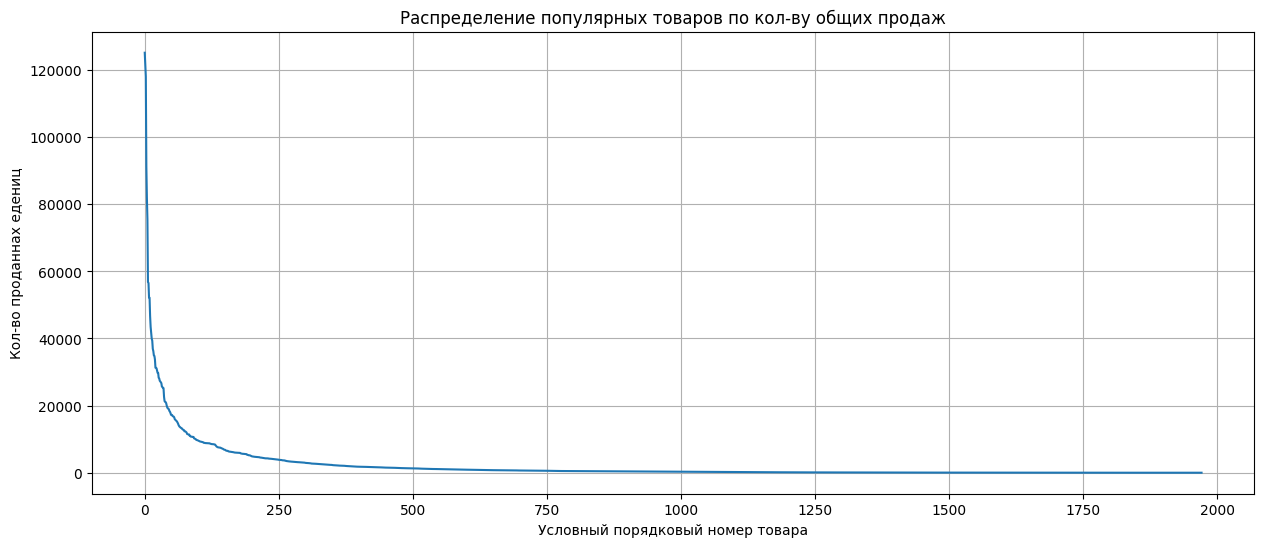

In [31]:
# ТОП товаров по кол-ву продаж
group_sku = group_sales.groupby('pr_sku_id')[['pr_sales_in_units', 'pr_sales_in_rub']].sum()

top_sku_by_units = group_sku.sort_values('pr_sales_in_units', ascending=False).reset_index(inplace=False)
display(top_sku_by_units)

top_sku_by_units['pr_sales_in_units'].plot(title='Распределение популярных товаров по кол-ву общих продаж',
                                           xlabel='Условный порядковый номер товара',
                                           ylabel='Кол-во проданнах едениц',
                                           figsize=FIGSIZE,
                                           grid=True);

,pr_sku_id,pr_sales_in_units,pr_sales_in_rub
0,c0e3f3bd815a862433bc3399c487926b,117922.0,14904282.0
1,4e824a65fbd01f1708131bd247842688,25181.0,12897895.0
2,5fb6bfa7b7d9a415d5f95d3951e2a35d,56480.0,8289040.0
3,4b083e10f6cd2f4360c5425d05be6386,91168.0,7997036.0
4,4a04104f09c6ea3e807666cce0c294d5,13305.0,7022692.0
...,...,...,...
1967,ed13e9303dfe637db6d4a327534f72b4,3.0,45.0
1968,48d8820abfb51f47e0975f797b1497e3,2.0,37.0
1969,5c70177d1170a79b9ff82d4459027c44,1.0,33.0
1970,48bb4fc3b178d1131f477296faebf138,2.0,30.0


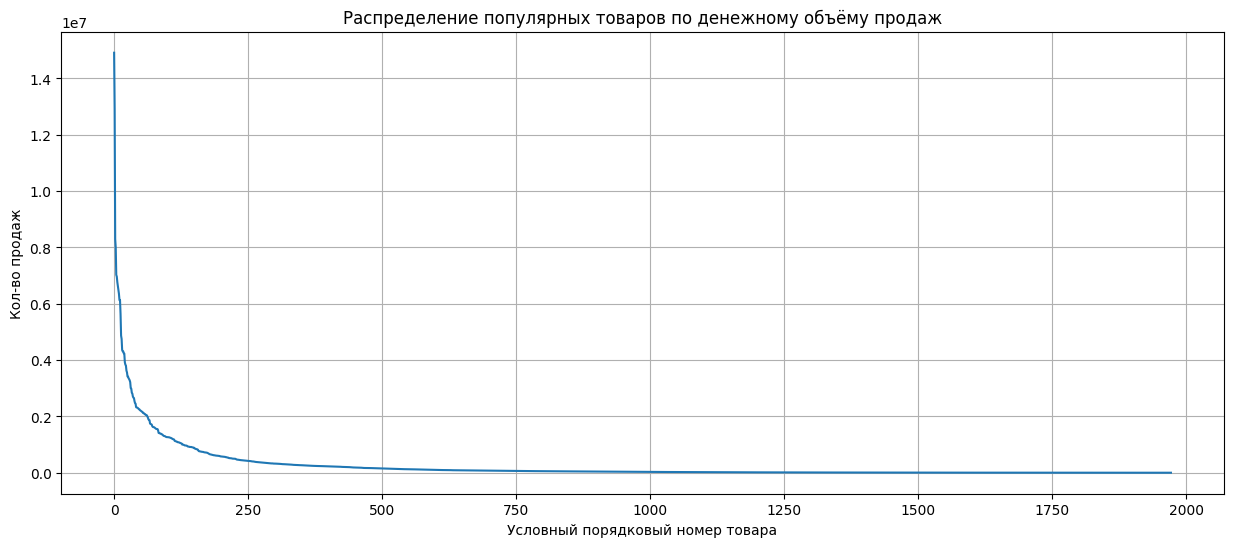

In [32]:
# ТОП товаров по денежному объёму продаж
top_sku_by_rub = group_sku.sort_values('pr_sales_in_rub', ascending=False).reset_index(inplace=False)
display(top_sku_by_rub)

top_sku_by_rub['pr_sales_in_rub'].plot(title='Распределение популярных товаров по денежному объёму продаж',
                                       xlabel='Условный порядковый номер товара',
                                       ylabel='Кол-во продаж',
                                       figsize=FIGSIZE,
                                       grid=True);

На этом графиках наглядно можно убедиться, что из почти двух тысячного ассортимента, лишь пара сотен товаров составляет большинство продаж. На этом этапе произойдёт отбор популярных товаров, с которыми продолжится дальнейшая работы.

Можно подойти к вопросу формирования top-N с другой стороны. Критериев для отбора может быть несколько. В первую очередь это _количество продаж_ или _денежный объём_. По мере увеличения ТОПа, перечень лидеров будет пересекаться в том и другом списке.

In [33]:
# сравниение ТОПов
for n in range(50, 251, 25):
    top_n_sku_by_units = top_sku_by_units.head(n)
    top_n_sku_by_rub   = top_sku_by_rub.head(n)
    print('TOP-{} - Пересечение товаров: {:.1%}'.format(n, top_n_sku_by_units.merge(top_n_sku_by_rub).shape[0] / n))

print('\nДоля выручки TOP-150: {:.1%} всех товаров.'.format(top_sku_by_units.head(150)['pr_sales_in_rub'].sum() /
                                                            group_sku['pr_sales_in_rub'].sum()))

top_150_sku_by_units = top_sku_by_units.head(150)['pr_sku_id'].values

del group_sku
del top_sku_by_rub
del top_sku_by_units
del top_n_sku_by_rub
del top_n_sku_by_units

TOP-50 - Пересечение товаров: 58.0%
TOP-75 - Пересечение товаров: 61.3%
TOP-100 - Пересечение товаров: 62.0%
TOP-125 - Пересечение товаров: 64.0%
TOP-150 - Пересечение товаров: 69.3%
TOP-175 - Пересечение товаров: 69.1%
TOP-200 - Пересечение товаров: 69.0%
TOP-225 - Пересечение товаров: 70.7%
TOP-250 - Пересечение товаров: 70.8%

Доля выручки TOP-150: 59.8% всех товаров.


Так вот для top-150 эти списки похожи на 69%, что является максимальным значением (см. фото). Я считаю, это ещё один ориентир для ТОПа продуктов. При этом аргументированный. Но предпочтение остаётся за кол-ом проданных товаров, поскольку именну эту величину необходимо предсказать, а так же это абсолютная величина в отличии от денежной суммы. Она зависит от цены товара.

### Корреляция между товарами

Подсчитать корреляцию Пирсона между товарами. Не признаками, а именно товарами.

Это позволяет найти "товары-соседи". К примеру если покупатель берёт _котлетку_, но высока вероятность что он возьмёт _макарошки_, а лучше _[пюрешку](https://youtu.be/A1Qb4zfurA8?si=LuFxfF8MO3FTZn5A)_.

Эффект Гало.

### Временные ряды

,count
date,
352,65
351,27
350,24
349,16
348,15


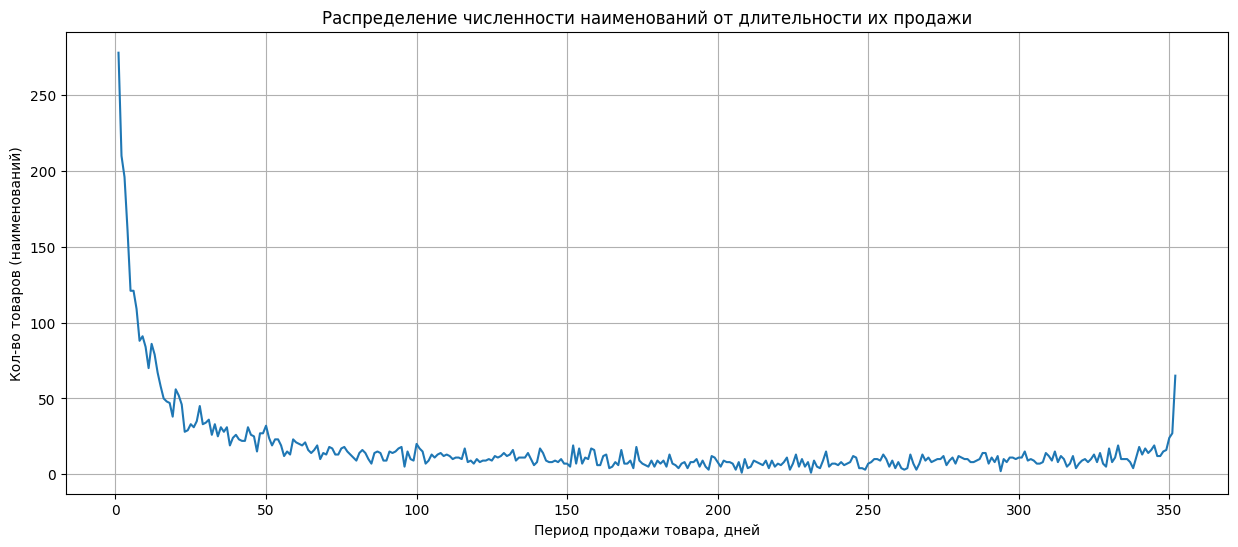

In [ ]:
# проверка продолжительности временного рядя
sales_count = group_sales.groupby(['st_id', 'pr_sku_id'])['date'].count()
display(sales_count.value_counts().to_frame().sort_index(ascending=False).head())

sales_count.value_counts().to_frame().sort_index(ascending=False).plot(
    title='Распределение численности наименований от длительности их продажи',
    xlabel='Период продажи товара, дней',
    ylabel='Кол-во товаров (наименований)',
    figsize=FIGSIZE,
    legend=False,
    grid=True);

В основной (тренировочной) выборке собраны данные за 352 дня. Лишь часть товаров продавалась непрерывно всё это время.

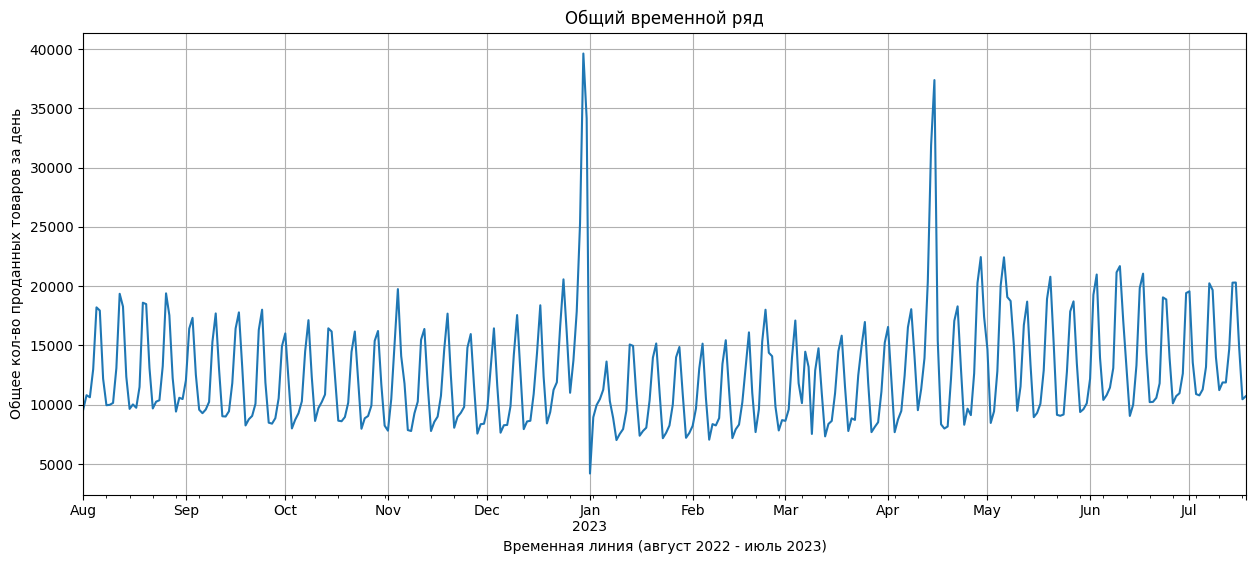

In [34]:
# Общий временной ряд
sales_df_train.groupby('date')['pr_sales_in_units'].sum().plot(
    title='Общий временной ряд',
    xlabel='Временная линия (август 2022 - июль 2023)',
    ylabel='Общее кол-во проданных товаров за день',
    figsize=FIGSIZE,
    grid=True);

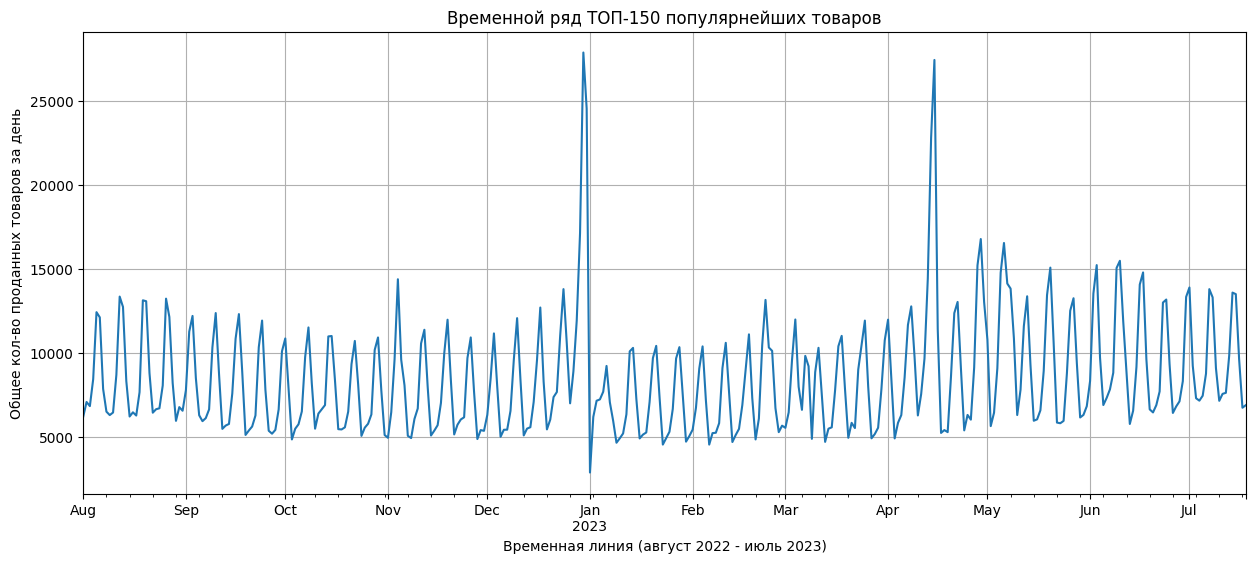

In [35]:
# малый временной ряд
group_sales[group_sales['pr_sku_id'].isin(top_150_sku_by_units)].groupby('date')['pr_sales_in_units'].sum().plot(
    title='Временной ряд ТОП-150 популярнейших товаров',
    xlabel='Временная линия (август 2022 - июль 2023)',
    ylabel='Общее кол-во проданных товаров за день',
    figsize=FIGSIZE,
    grid=True);

Временной ряд ТОП-150 популярнейших товаров внешне повторяет общий ряд всех продуктов. Это может говорить, что искуственное ограничение на 150 товарах не должно отразиться негативно. При первичном осмотре можно сказать, что сезоности и пиковые дни сохранились. На меньшей выборке можно проводить полноценный анализ, выводы из которого будут справедливы и для генеральной выборки.

**Промежуточный вывод:**

Продажи в закрытых магазинах составляет меньше 0.1% от общего числа, и собраны за короткий период: 1 авг - 8 сен 2022 года. Из 2050 наименований продавалось лишь 1991 товар. Все записи о продаже предоставлены только из "известных" магазинов, информация о которых есть в сводной таблице о магазинах.

Данные об общем кол-ве продаж содержит _крайне большие_ значения, а так же _отрицательные_ значения. Установлены границы. Нормальными будут считаться значения в диапазоне [0; 17.5], где 17.5 = Q3 + std (3-й квантиля + стандартного отклонения). Выбросами и аномалиями будут признаны ~5% данных.

Обнаружены:
- _убыточные операции_ (факт возврата - отсутствует, но есть уход денежных средств) - 8 объектов,
- _неучтённые операции_ (факт продажи - отсутствует, но есть поступление денежных средств) - 66 000 объектов (7.5% от общего числа).

Убыточные операции похожи на кражу товара и вычет его стоимости из "кассы". Небольшое количество таких объектов позволяет их удалить. Неучтённых операций, наоборот, очень много и прежде чем принять решение об их удалении необходим более подробный анализ. Возможно это неучтённая сумма, оставшаяся с прошлого дня.

___

## Исследовать признаки (EDA)

Посчитать цены:
- Стоимость одного товара (за день)
- Стоимость группы товаров (за день)

(День — Товар — Магазин — Продажа в штуках — Продажа в рублях — доля продаж по ПРОМО)

In [36]:
# итоговый набор данных
popular_sales = group_sales[group_sales['pr_sku_id'].isin(top_150_sku_by_units)]
display(popular_sales)

,st_id,pr_sku_id,date,pr_sales_in_units,pr_sales_in_rub,price,promo_price
36,084a8a9aa8cced9175bd07bc44998e75,c4a665596d4f67cecb7542c9fad407ee,2023-05-01,2.0,287.0,143.500000,NaN
37,084a8a9aa8cced9175bd07bc44998e75,c4a665596d4f67cecb7542c9fad407ee,2023-05-06,3.0,405.0,NaN,135.000000
344,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-01,6.0,1095.0,178.000000,191.500000
345,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-02,8.0,1578.0,195.500000,202.500000
346,16a5cdae362b8d27a1d8f8c7b78b4330,0094042bfeae507dc7f62acc8e5ed03a,2022-08-03,3.0,662.0,220.666667,NaN
...,...,...,...,...,...,...,...
660573,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-07-14,9.0,1177.0,NaN,130.777778
660574,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-07-15,6.0,884.0,NaN,147.333333
660575,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-07-16,12.0,1674.0,NaN,139.500000
660576,fa7cdfad1a5aaf8370ebeda47a1ff1c3,fe50ae64d08d4f8245aaabc55d1baf79,2023-07-17,7.0,911.0,NaN,130.142857


In [37]:
# статистическая информация по магазинам (количество и объём продаж)
popular_sales.groupby('st_id')[['pr_sales_in_units', 'pr_sales_in_rub']].agg(
    ['count','min', 'median', 'mean', 'max', 'sum'])

pr_sales_in_units                         \
                                             count  min median       mean   
st_id                                                                       
084a8a9aa8cced9175bd07bc44998e75                 2  2.0    2.5   2.500000   
16a5cdae362b8d27a1d8f8c7b78b4330             40358  1.0    8.0  15.741018   
1ecfb463472ec9115b10c292ef8bc986              6265  1.0    5.0   6.389306   
42a0e188f5033bc65bf8d78622277c4e             38894  1.0    6.0  13.307760   
53e19f3dbb211f20b20b45668303c1b6               865  1.0    4.0   4.452023   
6364d3f0f495b6ab9dcf8d3b5c6e0b01             36621  1.0    5.0  10.501707   
bd470ca955d9497bbcb808e59952fffc               259  1.0    4.0   4.725869   
c81e728d9d4c2f636f067f89cc14862c             37326  1.0    9.0  15.330869   
f7e6c85504ce6e82442c770f7c8606f0             35354  1.0    6.0  12.735532   
fa7cdfad1a5aaf8370ebeda47a1ff1c3             35095  1.0    5.0  11.204616   

                                                   pr_sales_in_rub         \
                                     max       sum           count    min   
st_id                                                                       
084a8a9aa8cced9175bd07bc44998e75     3.0       5.0               2  287.0   
16a5cdae362b8d27a1d8f8c7b78b4330  1271.0  635276.0           40358    3.0   
1ecfb463472ec9115b10c292ef8bc986   127.0   40029.0            6265    8.0   
42a0e188f5033bc65bf8d78622277c4e  1236.0  517592.0           38894    1.0   
53e19f3dbb211f20b20b45668303c1b6    26.0    3851.0             865    1.0   
6364d3f0f495b6ab9dcf8d3b5c6e0b01  1596.0  384583.0           36621    4.0   
bd470ca955d9497bbcb808e59952fffc    19.0    1224.0             259   24.0   
c81e728d9d4c2f636f067f89cc14862c   917.0  572240.0           37326    3.0   
f7e6c85504ce6e82442c770f7c8606f0   959.0  450252.0           35354    1.0   
fa7cdfad1a5aaf8370ebeda47a1ff1c3  2362.0  393226.0           35095    3.0   

                                                                            
                                 median         mean       max         sum  
st_id                                                                       
084a8a9aa8cced9175bd07bc44998e75  346.0   346.000000     405.0       692.0  
16a5cdae362b8d27a1d8f8c7b78b4330  734.0  1807.851653  156241.0  72961277.0  
1ecfb463472ec9115b10c292ef8bc986  217.0   304.608140    5678.0   1908370.0  
42a0e188f5033bc65bf8d78622277c4e  580.0  1432.569111  183265.0  55718343.0  
53e19f3dbb211f20b20b45668303c1b6  159.0   189.302890    1241.0    163747.0  
6364d3f0f495b6ab9dcf8d3b5c6e0b01  454.0  1120.495262   96692.0  41033657.0  
bd470ca955d9497bbcb808e59952fffc  173.0   186.011583     651.0     48177.0  
c81e728d9d4c2f636f067f89cc14862c  669.0  1387.744039   66525.0  51798934.0  
f7e6c85504ce6e82442c770f7c8606f0  565.0  1285.710104   75333.0  45454995.0  
fa7cdfad1a5aaf8370ebeda47a1ff1c3  537.0  1216.561504   62863.0  42695226.0

In [38]:
# анализ непопулярного магазина
st_id = '084a8a9aa8cced9175bd07bc44998e75'

object_count = sales_df_train[sales_df_train['st_id'] == st_id].shape[0]
since = sales_df_train.loc[sales_df_train['st_id'] == st_id, 'date'].min().date()
to = sales_df_train.loc[sales_df_train['st_id'] == st_id, 'date'].max().date()

print('Кол-во совершенных продаж: {} ({:.3%})'.format(object_count, object_count/sales_df_train.shape[0]))
print('Временной период: от {} до {} ({} дней)'.format(since, to, (to-since).days+1))

Кол-во совершенных продаж: 38 (0.005%)
Временной период: от 2023-03-26 до 2023-06-29 (96 дней)


Для всех 10 активных магазинов, разрабатываемая предсказательная модель будет очень полезна, поскольку в каждом из них товары продаются зачастую сотнями тысячами за год. За исключением `53e19f3dbb211f20b20b45668303c1b6` и `bd470ca955d9497bbcb808e59952fffc`. И особенно `084a8a9aa8cced9175bd07bc44998e75`.

In [39]:
# статистическая информация по товарам (количество и объём продаж)
sku_distribution = popular_sales.groupby('pr_sku_id').agg({'pr_sales_in_units':['count', 'median', 'mean', 'max', 'sum'],
                                                           'pr_sales_in_rub':['min', 'median', 'mean', 'max', 'sum'],
                                                           'price':['mean'],
                                                           'promo_price':['mean']})

sku_distribution['mean_discount'] = (1 - sku_distribution['promo_price'] / sku_distribution['price'])

display(sku_distribution)

pr_sales_in_units                           \
                                             count median       mean    max   
pr_sku_id                                                                     
0094042bfeae507dc7f62acc8e5ed03a              1610    5.0   7.896273   82.0   
050a8120e2a3b8751df8752fcc0323ef              1086    7.0  12.186004  107.0   
06076bf3c802444ebc7d5619ab64ceb6               753    8.0  12.289509  113.0   
0a2090e24b6ae62b0b0fcaa67a72b5a0              1599    9.0  21.744841  529.0   
0a68dd43c227b0e66d52665d6c3ca8ba              1797   16.0  29.015025  251.0   
...                                            ...    ...        ...    ...   
f152516615efd05cf4b4903b03d4a45d              2003    4.0   4.795307   32.0   
f26a7266746690b16a77b3073651d75d              1921    4.0   4.632483   61.0   
f3848b78b70702300c576fcd56a9addd              2065    5.0   6.886683   54.0   
fd55c4022acef4de4c7dc6cdd85a2d7a               273   99.0  99.479853  216.0   
fe50ae64d08d4f8245aaabc55d1baf79              2106    9.0  10.119658   88.0   

                                          pr_sales_in_rub          \
                                      sum             min  median   
pr_sku_id                                                           
0094042bfeae507dc7f62acc8e5ed03a  12713.0            33.0   818.0   
050a8120e2a3b8751df8752fcc0323ef  13234.0            74.0  1074.0   
06076bf3c802444ebc7d5619ab64ceb6   9254.0           560.0  3355.0   
0a2090e24b6ae62b0b0fcaa67a72b5a0  34770.0            55.0  1280.0   
0a68dd43c227b0e66d52665d6c3ca8ba  52140.0            93.0  2259.0   
...                                   ...             ...     ...   
f152516615efd05cf4b4903b03d4a45d   9605.0            56.0   503.0   
f26a7266746690b16a77b3073651d75d   8899.0           104.0   963.0   
f3848b78b70702300c576fcd56a9addd  14221.0            54.0   621.0   
fd55c4022acef4de4c7dc6cdd85a2d7a  27158.0            49.0  5520.0   
fe50ae64d08d4f8245aaabc55d1baf79  21312.0            80.0  1229.0   

                                                                        price  \
                                         mean      max        sum        mean   
pr_sku_id                                                                       
0094042bfeae507dc7f62acc8e5ed03a  1352.002484  13404.0  2176724.0  193.890874   
050a8120e2a3b8751df8752fcc0323ef  1913.164825  14084.0  2077697.0  182.066594   
06076bf3c802444ebc7d5619ab64ceb6  4811.610890  41774.0  3623143.0  467.454926   
0a2090e24b6ae62b0b0fcaa67a72b5a0  2693.064415  66525.0  4306210.0  146.374379   
0a68dd43c227b0e66d52665d6c3ca8ba  3871.871452  30347.0  6957753.0  162.292956   
...                                       ...      ...        ...         ...   
f152516615efd05cf4b4903b03d4a45d   627.062906   4423.0  1256007.0  135.905224   
f26a7266746690b16a77b3073651d75d  1204.478397  15981.0  2313803.0  281.387336   
f3848b78b70702300c576fcd56a9addd   802.527361   6605.0  1657219.0  121.607158   
fd55c4022acef4de4c7dc6cdd85a2d7a  5665.820513  12623.0  1546769.0   58.567916   
fe50ae64d08d4f8245aaabc55d1baf79  1416.962963  13502.0  2984124.0  150.737728   

                                 promo_price mean_discount  
                                        mean                
pr_sku_id                                                   
0094042bfeae507dc7f62acc8e5ed03a  162.790274      0.160403  
050a8120e2a3b8751df8752fcc0323ef  148.930770      0.181998  
06076bf3c802444ebc7d5619ab64ceb6  395.357782      0.154233  
0a2090e24b6ae62b0b0fcaa67a72b5a0  123.565349      0.155827  
0a68dd43c227b0e66d52665d6c3ca8ba  131.554601      0.189400  
...                                      ...           ...  
f152516615efd05cf4b4903b03d4a45d  116.812084      0.140489  
f26a7266746690b16a77b3073651d75d  230.781055      0.179846  
f3848b78b70702300c576fcd56a9addd  102.304417      0.158730  
fd55c4022acef4de4c7dc6cdd85a2d7a   53.447090      0.087434  
fe50ae64d08d4f8245aaabc55d1baf7

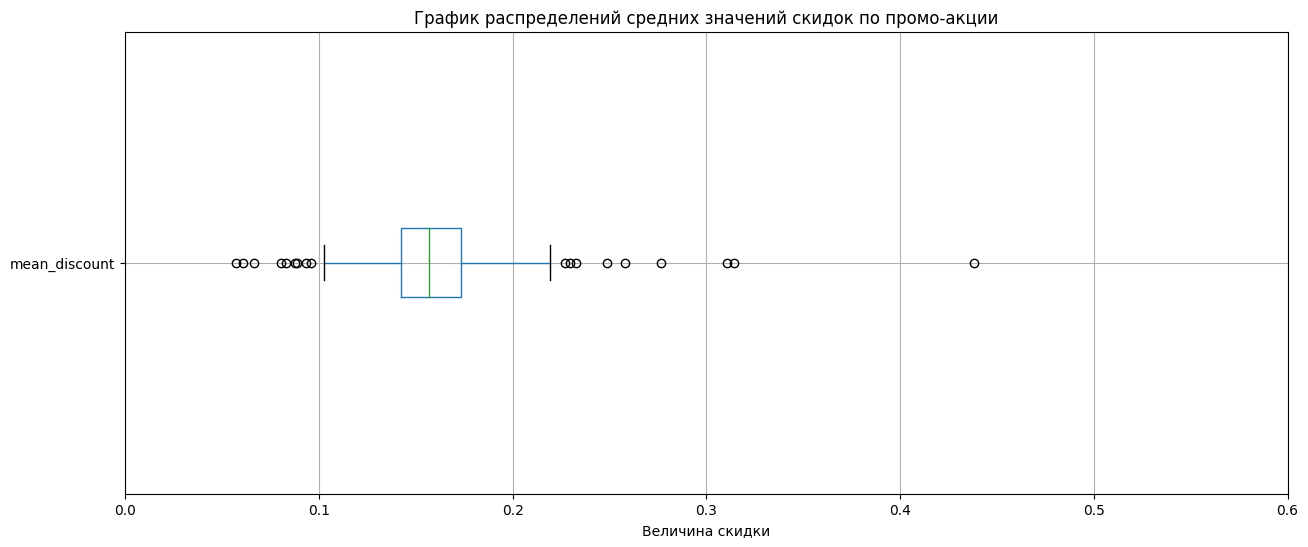

In [40]:
plt.figure(figsize=FIGSIZE)
sku_distribution.boxplot('mean_discount', vert=False)
plt.title('График распределений средних значений скидок по промо-акции')
plt.xlabel('Величина скидки')
plt.xlim(0.0, 0.6)
plt.grid(True)
plt.show()

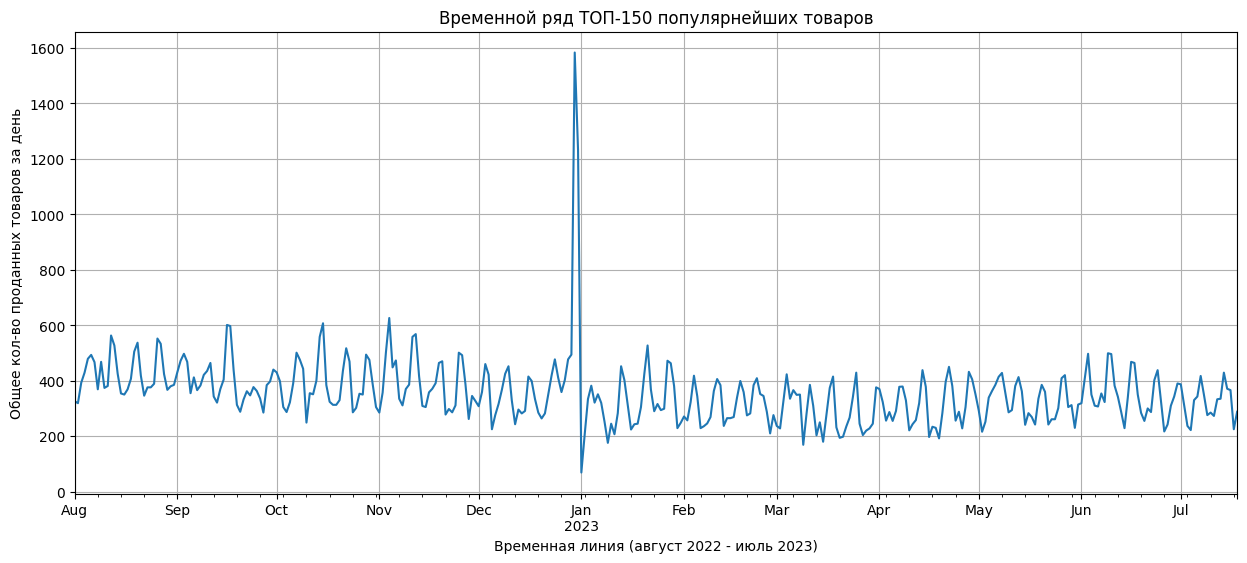

In [41]:
# временной ряд товара №0
group_sales[group_sales['pr_sku_id'] == top_150_sku_by_units[0]].groupby('date')['pr_sales_in_units'].sum().plot(
    title='Временной ряд ТОП-150 популярнейших товаров',
    xlabel='Временная линия (август 2022 - июль 2023)',
    ylabel='Общее кол-во проданных товаров за день',
    figsize=FIGSIZE,
    grid=True);

**Промежуточный вывод:**

Вычисленную среднюю стоимость товара и его скидки (`price`, `promo_price`, `mean_discount`) можно добавить в справочную таблицу о товарах `pr_df`, и использовать как вспомогательную фичу (хар-ку товара) при обучении.

___

## Фича-инжиниринг

**Ориентировочный план:**
   - Лаговые признаки (признаки за предыдущие периоды)
   - Скользящие средние
   - Временные признаки
   - Использовать библиотеку `TSFresh` (генерирует множество признаков)
   - Построить прогноз временных рядов с использованием `ARIMA` и `FaceBook Profet`
   - Сезонные признаки (покажем откуда грузить данные по погоде) * — доп. источник
   - Исследовать другие таблицы и сформировать фичи на свое усмотрение

Перечень фичей:
- магазин и некоторые его хар-ки,
- товар и некоторые его хар-ки,
- дата и сопутствующие данные (день недели, прадник/нет, и т.п.),

Что является таргетом? `pr_sales_in_units`? Тогда нужно учесть кол-во из `pr_promo_sales_in_units`. И нужен ли в таком случае флаг акции?

In [42]:
# пробный датасет для первых шагов в обучении модели
test_popular_sales = popular_sales.copy()
test_popular_sales.fillna(0, inplace=True)
test_popular_sales.sort_values(by='date', inplace=True)
test_popular_sales.reset_index(drop=True, inplace=True)
test_popular_sales.drop(['pr_sales_in_rub', 'price', 'promo_price'], axis=1, inplace=True)

display(test_popular_sales)

,st_id,pr_sku_id,date,pr_sales_in_units
0,42a0e188f5033bc65bf8d78622277c4e,22988026fe85fde60d8bf777ab6bc3b4,2022-08-01,1.0
1,fa7cdfad1a5aaf8370ebeda47a1ff1c3,22988026fe85fde60d8bf777ab6bc3b4,2022-08-01,1.0
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,70080bba1f176e070456abff52203013,2022-08-01,1.0
3,fa7cdfad1a5aaf8370ebeda47a1ff1c3,58ebafabd92e2e3a80d86b7bb7e88eda,2022-08-01,1.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,4c8f26ea6f6790779345b500b2f70e9b,2022-08-01,22.0
...,...,...,...,...
231034,42a0e188f5033bc65bf8d78622277c4e,ec64491cf0ea4b8a3cde5e351582631d,2023-07-18,4.0
231035,fa7cdfad1a5aaf8370ebeda47a1ff1c3,57eaf5659b0371dbef7bb6cee4a14e71,2023-07-18,4.0
231036,42a0e188f5033bc65bf8d78622277c4e,ee441af33a59b66a2026b029a24f269a,2023-07-18,3.0
231037,fa7cdfad1a5aaf8370ebeda47a1ff1c3,5aa2f6e00873f8c90b00cd15d670daa1,2023-07-18,11.0


In [43]:
# функция создание признаков
def make_time_features(df, max_lag:int, window_size:int):
    
    # отстающие (предыдущие) признаки / lag features
    #for lag in range (1, max_lag+1):
    #    df['num_orders_{}'.format(lag)] = df['num_orders'].shift(periods=lag, fill_value=df.iloc[-1, lag-1])
    
    # скользящее среднее / rolling mean
    #df['rolling_mean'] = df['num_orders'].shift().rolling(window_size).mean()
    
    # календарные признаки / calendar features
    #df['year']      = df['date'].dt.year
    df['month']     = df['date'].dt.month
    df['dayofweek'] = df['date'].dt.dayofweek
    df['day']       = df['date'].dt.day
    
    # удаление новообразованных пустых объектов в начале
    #df.dropna(inplace=True)
    df.drop(['date'], axis=1, inplace=True)

In [44]:
# дополнение признаков
test_popular_sales = test_popular_sales.merge(pr_st, on='st_id', how='left')
test_popular_sales.drop(['st_is_active', 'st_city_id'], axis=1, inplace=True)

test_popular_sales = test_popular_sales.merge(pr_df, on='pr_sku_id', how='left')

make_time_features(test_popular_sales, max_lag=2, window_size=3)

display(test_popular_sales)

,st_id,pr_sku_id,pr_sales_in_units,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,month,dayofweek,day
0,42a0e188f5033bc65bf8d78622277c4e,22988026fe85fde60d8bf777ab6bc3b4,1.0,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17,8,0,1
1,fa7cdfad1a5aaf8370ebeda47a1ff1c3,22988026fe85fde60d8bf777ab6bc3b4,1.0,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,c74d97b01eae257e44aa9d5bade97baf,f3173935ed8ac4bf073c1bcd63171f8a,5fd72b9fc7118bd36a137d7cea8c588a,17,8,0,1
2,6364d3f0f495b6ab9dcf8d3b5c6e0b01,70080bba1f176e070456abff52203013,1.0,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17,8,0,1
3,fa7cdfad1a5aaf8370ebeda47a1ff1c3,58ebafabd92e2e3a80d86b7bb7e88eda,1.0,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,aab3238922bcc25a6f606eb525ffdc56,28fc2782ea7ef51c1104ccf7b9bea13d,7a8aebb07d6e8ba9da453ec0f3f359a4,1,8,0,1
4,16a5cdae362b8d27a1d8f8c7b78b4330,4c8f26ea6f6790779345b500b2f70e9b,22.0,296bd0cc6e735f9d7488ebc8fbc19130,1,2,8,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,45551f4c29881972ae5ed3666a5b1b8b,1,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231034,42a0e188f5033bc65bf8d78622277c4e,ec64491cf0ea4b8a3cde5e351582631d,4.0,da742b3cfca5388aaf9af28a726a3c30,1,1,12,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,1e2248e0a1305fdf1dca5510e06a2b96,17,7,1,18
231035,fa7cdfad1a5aaf8370ebeda47a1ff1c3,57eaf5659b0371dbef7bb6cee4a14e71,4.0,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,c74d97b01eae257e44aa9d5bade97baf,1bc0249a6412ef49b07fe6f62e6dc8de,d407a3ebb4ab9b0d68b224486f8b8dad,17,7,1,18
231036,42a0e188f5033bc65bf8d78622277c4e,ee441af33a59b66a2026b029a24f269a,3.0,da742b3cfca5388aaf9af28a726a3c30,1,1,12,6512bd43d9caa6e02c990b0a82652dca,e58cc5ca94270acaceed13bc82dfedf7,120e4b609af49ff7b17c3b90e7a28435,1,7,1,18
231037,fa7cdfad1a5aaf8370ebeda47a1ff1c3,5aa2f6e00873f8c90b00cd15d670daa1,11.0,296bd0cc6e735f9d7488ebc8fbc19130,1,1,12,c74d97b01eae257e44aa9d5bade97baf,c559da2ba967eb820766939a658022c8,34d2777e78ccf007523e2dd1fcea6b2d,17,7,1,18


In [45]:
# выделение признаков
target = test_popular_sales['pr_sales_in_units']
features = test_popular_sales.drop(['pr_sales_in_units'], axis=1)

# выделение тренировочной выборки
X_train, X_valid, y_train, y_valid = train_test_split(features,
                                                      target,
                                                      shuffle = False,
                                                      train_size = 0.80,
                                                      random_state = RANDOM_STATE)

In [46]:
# кодирование категориальных признаков
category = ['st_id', 'pr_sku_id', 'st_division_code', 'pr_group_id', 'pr_cat_id', 'pr_subcat_id'] # , 'st_city_id'

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=(-1))
ord_encoder.fit(X_train[category])
X_train[category] = ord_encoder.transform(X_train[category])
X_valid[category] = ord_encoder.transform(X_valid[category])

display(X_train)
print(X_train.info())

,st_id,pr_sku_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,month,dayofweek,day
0,3.0,19.0,3.0,1,1,12,5.0,15.0,16.0,17,8,0,1
1,9.0,19.0,0.0,1,1,12,5.0,15.0,16.0,17,8,0,1
2,5.0,73.0,3.0,1,1,12,5.0,1.0,46.0,17,8,0,1
3,9.0,50.0,0.0,1,1,12,2.0,3.0,21.0,1,8,0,1
4,1.0,41.0,0.0,1,2,8,3.0,18.0,12.0,1,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184826,9.0,73.0,0.0,1,1,12,5.0,1.0,46.0,17,5,4,12
184827,3.0,112.0,3.0,1,1,12,2.0,8.0,26.0,1,5,4,12
184828,9.0,118.0,0.0,1,1,12,2.0,0.0,33.0,1,5,4,12
184829,5.0,108.0,3.0,1,1,12,1.0,14.0,43.0,1,5,4,12


<class 'pandas.core.frame.DataFrame'>
Index: 184831 entries, 0 to 184830
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   st_id              184831 non-null  float64
 1   pr_sku_id          184831 non-null  float64
 2   st_division_code   184831 non-null  float64
 3   st_type_format_id  184831 non-null  int64  
 4   st_type_loc_id     184831 non-null  int64  
 5   st_type_size_id    184831 non-null  int64  
 6   pr_group_id        184831 non-null  float64
 7   pr_cat_id          184831 non-null  float64
 8   pr_subcat_id       184831 non-null  float64
 9   pr_uom_id          184831 non-null  int64  
 10  month              184831 non-null  int32  
 11  dayofweek          184831 non-null  int32  
 12  day                184831 non-null  int32  
dtypes: float64(6), int32(3), int64(4)
memory usage: 17.6 MB
None


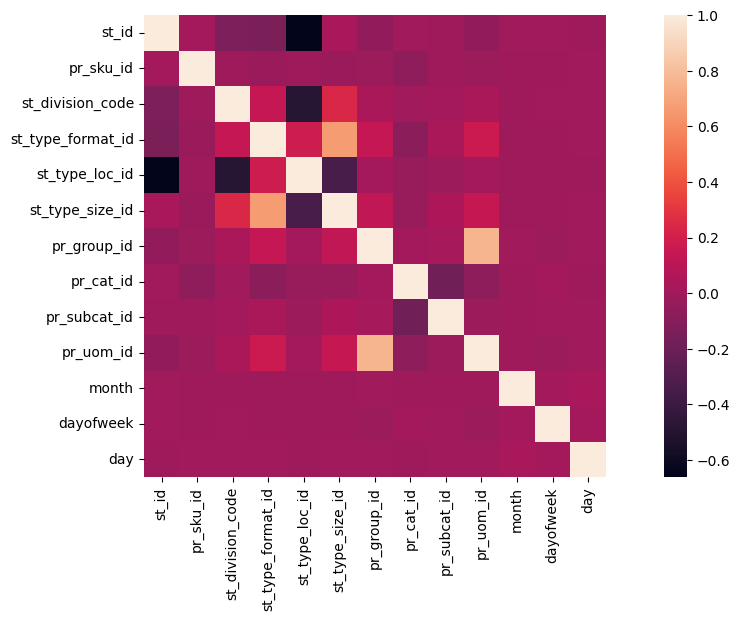

In [47]:
# матрица корреляций
plt.figure(figsize=FIGSIZE)
sns.heatmap(X_train.corr(), square=True);

**Промежуточный вывод:**


___

## Построить ML-модель

**Ориентировочный план:**
- Перебрать регрессией
- Обучить регрессию на деревьях
- Обучить бустинги
- Обучить `ARIMA`

### Прототип №1

In [48]:
# функция метрики wape
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [49]:
# Линейная регрессия
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
prediction = LR_model.predict(X_valid)
wape_valid = wape(y_valid, prediction)

print('Метрика WAPE: {:.1%}'.format(wape_valid))


Метрика WAPE: 80.6%


In [50]:
# Dummy-модель
dummy_mean = DummyRegressor()
dummy_mean.fit(X_train, y_train)
dummy_prediction = dummy_mean.predict(X_valid)
wape_valid = wape(y_valid, dummy_prediction)

print('Метрика WAPE: {:.1%}'.format(wape_valid))

Метрика WAPE: 84.1%


### Прототип №2

In [51]:
# проверка непрерывности
best_sku = group_sales[(group_sales['pr_sku_id'] == top_150_sku_by_units[0]) &
                       (group_sales['st_id'] == '16a5cdae362b8d27a1d8f8c7b78b4330')]

best_sku.set_index('date', inplace=True)

print('Хронологическая последовательность прямая   :', best_sku.index.is_monotonic_increasing)
print('Хронологическая последовательность обратная :', best_sku.index.is_monotonic_decreasing)
print(best_sku.info())
display(best_sku.head())

Хронологическая последовательность прямая   : True
Хронологическая последовательность обратная : False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2022-08-01 to 2023-07-18
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   st_id              352 non-null    object 
 1   pr_sku_id          352 non-null    object 
 2   pr_sales_in_units  352 non-null    float64
 3   pr_sales_in_rub    352 non-null    float64
 4   price              352 non-null    float64
 5   promo_price        352 non-null    float64
dtypes: float64(4), object(2)
memory usage: 19.2+ KB
None


,st_id,pr_sku_id,pr_sales_in_units,pr_sales_in_rub,price,promo_price
date,,,,,,
2022-08-01,16a5cdae362b8d27a1d8f8c7b78b4330,62d4af457ba2540ce0898a211c0cd17a,121.0,1744.0,14.514019,13.642857
2022-08-02,16a5cdae362b8d27a1d8f8c7b78b4330,62d4af457ba2540ce0898a211c0cd17a,121.0,1738.0,14.441441,13.500000
2022-08-03,16a5cdae362b8d27a1d8f8c7b78b4330,62d4af457ba2540ce0898a211c0cd17a,141.0,2020.0,14.475806,13.235294
2022-08-04,16a5cdae362b8d27a1d8f8c7b78b4330,62d4af457ba2540ce0898a211c0cd17a,161.0,2321.0,14.489655,13.750000
2022-08-05,16a5cdae362b8d27a1d8f8c7b78b4330,62d4af457ba2540ce0898a211c0cd17a,183.0,2641.0,14.485030,13.875000


In [ ]:
# функция создание признаков
def make_time_features_v2(df, max_lag:int, window_size:int):
    
    # отстающие (предыдущие) признаки / lag features
    for lag in range (1, max_lag+1):
        df['pr_sales_in_units_{}'.format(lag)] = df['pr_sales_in_units'].shift(periods=lag, fill_value=df.iloc[-1, lag-1])
    
    # скользящее среднее / rolling mean
    df['rolling_mean'] = df['pr_sales_in_units'].shift().rolling(window_size).mean()
    
    # удаление новообразованных пустых объектов в начале
    df.dropna(inplace=True)

    # календарные признаки / calendar features
    #df['year']      = df.index.year
    df['month']     = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['day']       = df.index.day

In [54]:
# дополнение/удаление признаков
best_sku.drop(['st_id', 'pr_sku_id', 'promo_price'], axis=1, inplace=True)

make_time_features_v2(best_sku, max_lag=2, window_size=3)

display(best_sku)

D:\Users\Dispers\AppData\Local\Temp\ipykernel_22800\876887526.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_sku.drop(['st_id', 'pr_sku_id', 'promo_price'], axis=1, inplace=True)
D:\Users\Dispers\AppData\Local\Temp\ipykernel_22800\1569098335.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pr_sales_in_units_{}'.format(lag)] = df['pr_sales_in_units'].shift(periods=lag, fill_value=df.iloc[-1, lag-1])
D:\Users\Dispers\AppData\Local\Temp\ipykernel_22800\1569098335.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

,pr_sales_in_units,pr_sales_in_rub,price,pr_sales_in_units_1,pr_sales_in_units_2,rolling_mean,month,dayofweek,day
date,,,,,,,,,
2022-08-04,161.0,2321.0,14.489655,141.0,121.0,127.666667,8,3,4
2022-08-05,183.0,2641.0,14.485030,161.0,141.0,141.000000,8,4,5
2022-08-06,186.0,2640.0,14.432927,183.0,161.0,161.666667,8,5,6
2022-08-07,213.0,3067.0,14.505263,186.0,183.0,176.666667,8,6,7
2022-08-08,122.0,1713.0,14.291262,213.0,186.0,194.000000,8,0,8
...,...,...,...,...,...,...,...,...,...
2023-07-14,134.0,2289.0,17.218487,106.0,120.0,112.000000,7,4,14
2023-07-15,151.0,2552.0,17.036496,134.0,106.0,120.000000,7,5,15
2023-07-16,118.0,2000.0,17.160377,151.0,134.0,130.333333,7,6,16


In [56]:
# выделение признаков
target = best_sku['pr_sales_in_units']
features = best_sku.drop(['pr_sales_in_units'], axis=1)

# выделение тренировочной выборки
X_train, X_valid, y_train, y_valid = train_test_split(features,
                                                      target,
                                                      shuffle = False,
                                                      train_size = 0.80,
                                                      random_state = RANDOM_STATE)

In [69]:
# Линейная регрессия
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
prediction = LR_model.predict(X_valid)
wape_valid = wape(y_valid, prediction)

print('Метрика WAPE: {:.1%}'.format(wape_valid))

Метрика WAPE: 3.1%


In [58]:
# Dummy-модель
dummy_mean = DummyRegressor()
dummy_mean.fit(X_train, y_train)
dummy_prediction = dummy_mean.predict(X_valid)
wape_valid = wape(y_valid, dummy_prediction)

print('Метрика WAPE: {:.1%}'.format(wape_valid))

Метрика WAPE: 22.9%


**Промежуточный вывод:**


___